Notebook to look into gen particle collection in FF ntuples

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
#plotting
import matplotlib.pyplot as plt
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from analysis.tools import ffschema, sidm_processor
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)

<module 'analysis.tools.sidm_processor' from '/home/cms-jovyan/SIDM/analysis/studies/../../analysis/tools/sidm_processor.py'>

Just look at 2mu2e channel of 2mu2e sample

In [2]:
sample_dir = "root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/"
sample_name = "SIDM_XXTo2ATo2Mu2E_mXX-100_mA-1p2_ctau-9p6"
sample_file = f"{sample_dir}/{sample_name}_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_161703/0000/ffNtuple_1.root"

events = NanoEventsFactory.from_root(
    sample_file,
    treepath='ffNtuplizer/ffNtuple',
    schemaclass=ffschema.FFSchema,
    metadata = {
        "sample": sample_name, 
    },
).events()

In [3]:
channels = ["2mu2e"]
hists = ["base", "gen_base"]
p = sidm_processor.SidmProcessor(channels, hists)
out = p.process(events)

Take a look at some basic properties

In [4]:
ak.fields(events.gen)

['charge',
 'pid',
 'daupid',
 'daudr',
 'posx',
 'posy',
 'posz',
 'dauposdr',
 'dauposdz',
 'dauposdphi',
 'p4',
 'vtx',
 'dauvtx']

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f316c8b36a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

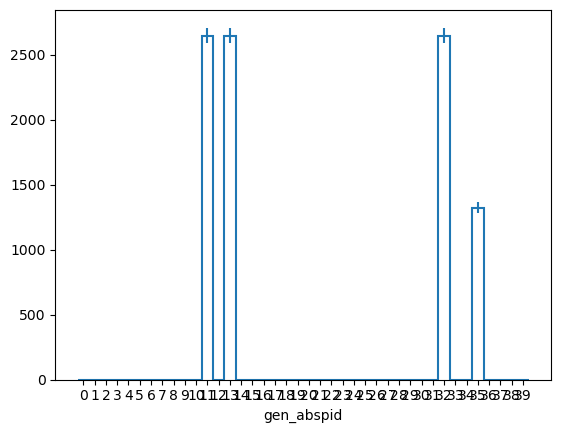

In [5]:
ch = channels[0]
hists = out[sample_name]["hists"]
hists["gen_abspid"][ch, :].plot()

In [6]:
set(ak.flatten(events.gen.pid))

{-13, -11, 11, 13, 32, 35}

So the only gen particles are electrons, muons, Z', and H0 (according to https://twiki.cern.ch/twiki/bin/view/Main/PdgId). I assume Z' is a stand-in for the dark photon and H0 is a stand-in for the DM bound state.

In [7]:
print(ak.num(events.gen))
print(set(ak.num(events.gen)))

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ... 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
{7}


In [8]:
for id in set(ak.flatten(events.gen.pid)):
    print(id, set(ak.num(events.gen.pid[events.gen.pid == id])))

32 {2}
35 {1}
11 {1}
13 {1}
-13 {1}
-11 {1}


Every single event has exactly 1 bound state, 2 dark photons, 2 e, and 2 mu. Presumably the e and mu are the dark photon daughters. Next I'll take a look at some gen-gen and gen-reco dR quantities.

WeightedSum(value=2648.9, variance=3660.49)

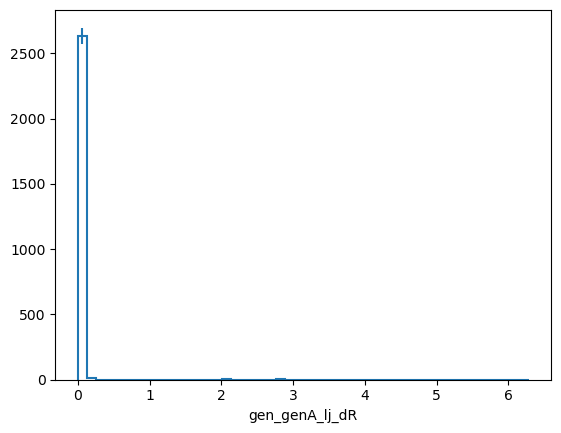

In [9]:
hists["genA_lj_dR"].plot()
hists["genA_lj_dR"].sum()

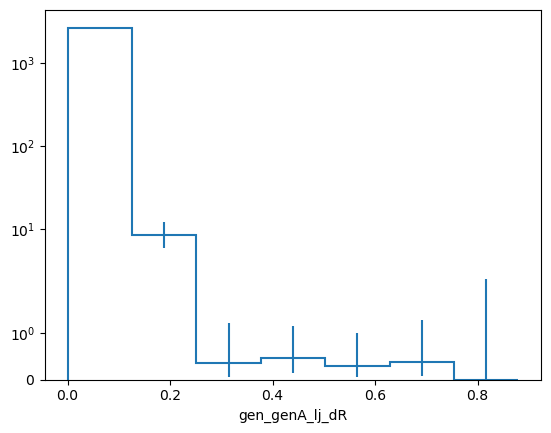

In [10]:
hists["genA_lj_dR"][:, :1j].plot()
plt.yscale("symlog")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f315afe0640>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

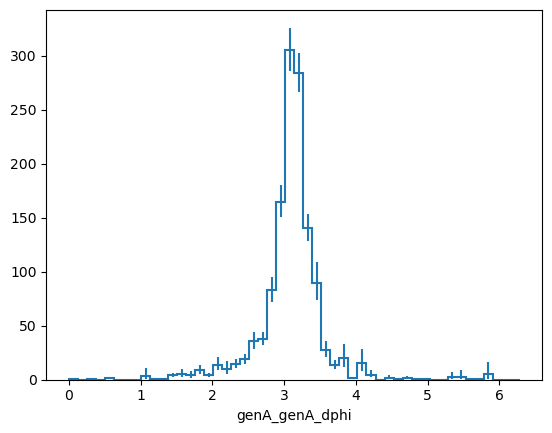

In [11]:
hists["genA_genA_dphi"].plot()

Cool, there's basically always a LJ right on top of each dark photon, and the dark photons are basically always back to back. This means a simple dR cut will work for matching LJs to dark photons.